In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gym
from gym import spaces
from collections import defaultdict

# データの読み込み
file_names = ["./gps.us.csv", "./rl.us.csv", "./abc.us.csv"]  # 読み込むCSVファイル名のリスト
stock_data = []  # 株価データを格納するリスト

for file in file_names:
    data = pd.read_csv(file, delimiter=',')  # CSVファイルを読み込む
    data['Date'] = pd.to_datetime(data['Date'])  # 'Date'列を日時形式に変換
    data = data[data['Date'] >= '2000-01-01']  # 2000年以降のデータにフィルタリング
    stock_data.append(data)  # データをリストに追加

# 共通の日付範囲を取得
common_dates = stock_data[0][['Date']]  # 最初のデータセットの日付を取得
for data in stock_data[1:]:
    common_dates = pd.merge(common_dates, data[['Date']], on='Date', how='inner')  # 日付を共通化

# 共通日付でフィルタリングし、リターンを計算
returns = pd.DataFrame({'Date': common_dates['Date']})  # 共通の日付を持つデータフレームを作成
for i, data in enumerate(stock_data):
    data = data[data['Date'].isin(common_dates['Date'])]  # 共通の日付にフィルタリング
    data.sort_values('Date', inplace=True)  # 日付でソート
    data[f'Return_{i}'] = data['Close'].pct_change()  # クローズ価格のパーセント変化を計算
    returns = pd.merge(returns, data[['Date', f'Return_{i}']], on='Date', how='inner')  # リターンを共通の日付でマージ

returns.set_index('Date', inplace=True)  # 日付をインデックスに設定
returns.dropna(inplace=True)  # NaN値を削除

# 強化学習環境の定義
class PortfolioEnv(gym.Env):
    def __init__(self, returns, initial_balance=1000):
        self.returns = returns  # リターンデータ
        self.n_assets = returns.shape[1]  # 資産の数
        self.initial_balance = initial_balance  # 初期バランス
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)  # 行動空間を定義
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)  # 観測空間を定義
        self.reset()  # 環境をリセット

    def reset(self):
        self.balance = self.initial_balance  # バランスを初期バランスにリセット
        self.current_step = 0  # 現在のステップをリセット
        self.portfolio = np.zeros(self.n_assets)  # ポートフォリオを初期化
        return self._next_observation()  # 次の観測を返す

    def _next_observation(self):
        return self.returns.iloc[self.current_step].values  # 現在のステップのリターンを返す

    def step(self, action):
        self.current_step += 1  # ステップを進める
        prev_balance = self.balance  # 前のバランスを保存

        # ポートフォリオの更新
        for i in range(self.n_assets):
            self.portfolio[i] += action[i]  # 各資産のアクションを反映

        # 新しいバランスの計算
        self.balance = prev_balance + np.sum(self.portfolio * self._next_observation())  # 新しいバランスを計算
        reward = self.balance - prev_balance  # 報酬を計算
        done = self.current_step >= len(self.returns) - 1  # 終了条件を設定

        obs = self._next_observation()  # 次の観測を取得
        return obs, reward, done, {}  # 観測、報酬、終了フラグ、追加情報を返す

# Q-Learningエージェントの定義
class QLearningAgent:
    def __init__(self, learning_rate, initial_epsilon, epsilon_decay, final_epsilon, discount_factor=0.95):
        self.q_values = defaultdict(lambda: np.zeros(3 ** len(file_names)))  # 各資産に対して3つのアクション（ホールド、バイ、セル）
        self.lr = learning_rate  # 学習率
        self.discount_factor = discount_factor  # 割引率
        self.epsilon = initial_epsilon  # 初期epsilon
        self.epsilon_decay = epsilon_decay  # epsilonの減衰率
        self.final_epsilon = final_epsilon  # 最終epsilon
        self.training_error = []  # 訓練エラーの記録

    def get_action(self, obs):
        if np.random.random() < self.epsilon:  # epsilonの確率でランダムな行動
            return [np.random.choice([0, 1, 2]) for _ in range(len(obs))]  # 各資産に対してランダムな行動を選択
        else:
            obs_idx = tuple((obs * 100).astype(int))  # 観測値をインデックスに変換
            return [int(np.argmax(self.q_values[obs_idx][i * 3:(i + 1) * 3])) for i in range(len(obs))]  # 各資産の最適行動を選択

    def update(self, obs, action, reward, next_obs):
        obs_idx = tuple((obs * 100).astype(int))  # 観測値をインデックスに変換
        next_obs_idx = tuple((next_obs * 100).astype(int))  # 次の観測値をインデックスに変換
        future_q_value = np.max(self.q_values[next_obs_idx])  # 次の状態の最大Q値を取得
        action_idx = sum([action[i] * (3 ** i) for i in range(len(action))])  # 現在のアクションのインデックスを計算
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[obs_idx][action_idx]  # 時間的差分を計算
        self.q_values[obs_idx][action_idx] += self.lr * temporal_difference  # Q値を更新
        self.training_error.append(temporal_difference)  # 訓練エラーを記録

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)  # epsilonを減少させる

# 環境とエージェントの初期化
env = PortfolioEnv(returns)  # 環境を初期化
agent = QLearningAgent(
    learning_rate=0.01,
    initial_epsilon=1.0,
    epsilon_decay=0.01,
    final_epsilon=0.1
)  # エージェントを初期化

# 訓練ループ
n_episodes = 1000  # エピソード数を設定
for episode in range(n_episodes):
    obs = env.reset()  # 環境をリセット
    done = False  # 終了フラグを初期化

    while not done:
        action = agent.get_action(obs)  # 行動を選択
        next_obs, reward, done, _ = env.step(action)  # 行動を実行して次の状態を取得
        agent.update(obs, action, reward, next_obs)  # エージェントを更新
        obs = next_obs  # 現在の観測を更新

    agent.decay_epsilon()  # epsilonを減衰

C:\Users\takah\AppData\Local\Temp\ipykernel_19036\3042841191.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('Date', inplace=True)  # 日付でソート
C:\Users\takah\AppData\Local\Temp\ipykernel_19036\3042841191.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Return_{i}'] = data['Close'].pct_change()  # クローズ価格のパーセント変化を計算
C:\Users\takah\AppData\Local\Temp\ipykernel_19036\3042841191.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

C:\Users\takah\AppData\Local\Temp\ipykernel_19036\248165849.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('Date', inplace=True)  # 日付でソート
C:\Users\takah\AppData\Local\Temp\ipykernel_19036\248165849.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Return_{i}'] = data['Close'].pct_change()  # クローズ価格のパーセント変化を計算
C:\Users\takah\AppData\Local\Temp\ipykernel_19036\248165849.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

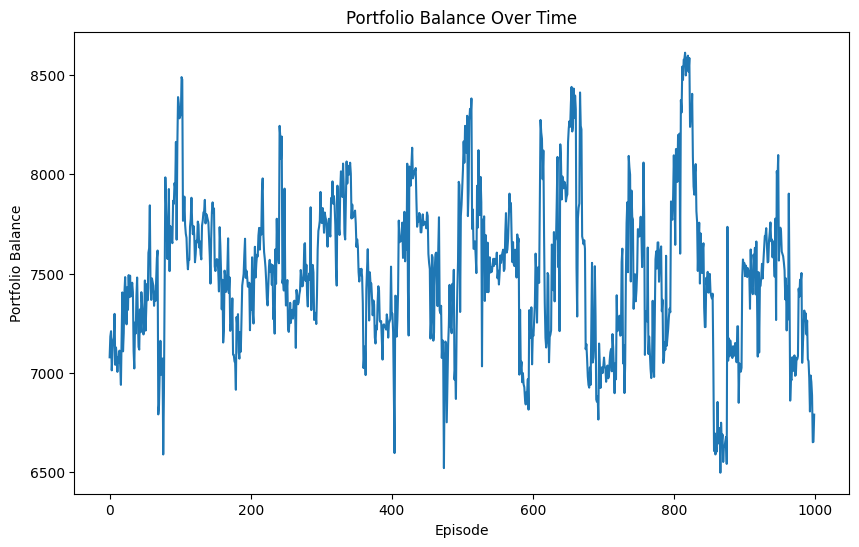

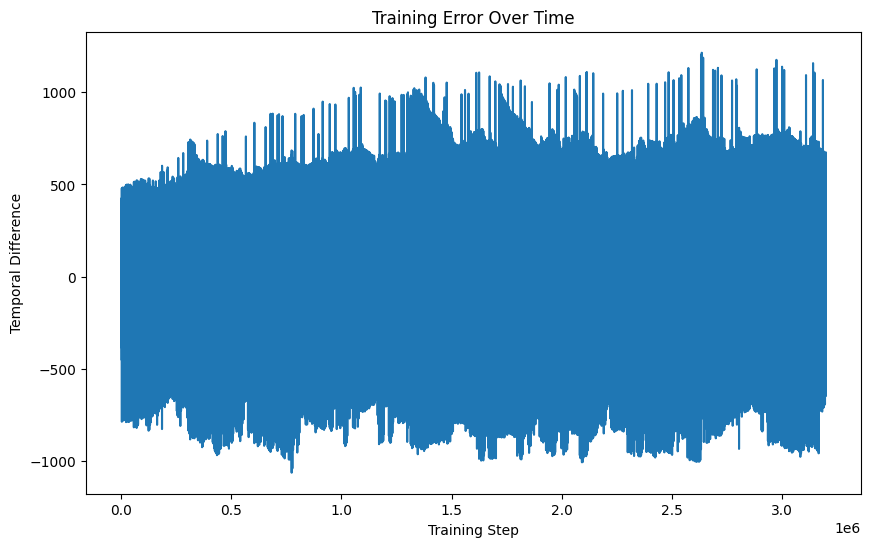

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gym
from gym import spaces
from collections import defaultdict

# データの読み込み
file_names = ["./gps.us.csv", "./rl.us.csv", "./abc.us.csv"]  # 読み込むCSVファイル名のリスト
stock_data = []  # 株価データを格納するリスト

for file in file_names:
    data = pd.read_csv(file, delimiter=',')  # CSVファイルを読み込む
    data['Date'] = pd.to_datetime(data['Date'])  # 'Date'列を日時形式に変換
    data = data[data['Date'] >= '2000-01-01']  # 2000年以降のデータにフィルタリング
    stock_data.append(data)  # データをリストに追加

# 共通の日付範囲を取得
common_dates = stock_data[0][['Date']]  # 最初のデータセットの日付を取得
for data in stock_data[1:]:
    common_dates = pd.merge(common_dates, data[['Date']], on='Date', how='inner')  # 日付を共通化

# 共通日付でフィルタリングし、リターンを計算
returns = pd.DataFrame({'Date': common_dates['Date']})  # 共通の日付を持つデータフレームを作成
for i, data in enumerate(stock_data):
    data = data[data['Date'].isin(common_dates['Date'])]  # 共通の日付にフィルタリング
    data.sort_values('Date', inplace=True)  # 日付でソート
    data[f'Return_{i}'] = data['Close'].pct_change()  # クローズ価格のパーセント変化を計算
    returns = pd.merge(returns, data[['Date', f'Return_{i}']], on='Date', how='inner')  # リターンを共通の日付でマージ

returns.set_index('Date', inplace=True)  # 日付をインデックスに設定
returns.dropna(inplace=True)  # NaN値を削除

# 強化学習環境の定義
class PortfolioEnv(gym.Env):
    def __init__(self, returns, initial_balance=1000):
        self.returns = returns  # リターンデータ
        self.n_assets = returns.shape[1]  # 資産の数
        self.initial_balance = initial_balance  # 初期バランス
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)  # 行動空間を定義
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)  # 観測空間を定義
        self.reset()  # 環境をリセット

    def reset(self):
        self.balance = self.initial_balance  # バランスを初期バランスにリセット
        self.current_step = 0  # 現在のステップをリセット
        self.portfolio = np.zeros(self.n_assets)  # ポートフォリオを初期化
        return self._next_observation()  # 次の観測を返す

    def _next_observation(self):
        return self.returns.iloc[self.current_step].values  # 現在のステップのリターンを返す

    def step(self, action):
        self.current_step += 1  # ステップを進める
        prev_balance = self.balance  # 前のバランスを保存

        # ポートフォリオの更新
        for i in range(self.n_assets):
            self.portfolio[i] += action[i]  # 各資産のアクションを反映

        # 新しいバランスの計算
        self.balance = prev_balance + np.sum(self.portfolio * self._next_observation())  # 新しいバランスを計算
        reward = self.balance - prev_balance  # 報酬を計算
        done = self.current_step >= len(self.returns) - 1  # 終了条件を設定

        obs = self._next_observation()  # 次の観測を取得
        return obs, reward, done, {}  # 観測、報酬、終了フラグ、追加情報を返す

# Q-Learningエージェントの定義
class QLearningAgent:
    def __init__(self, learning_rate, initial_epsilon, epsilon_decay, final_epsilon, discount_factor=0.95):
        self.q_values = defaultdict(lambda: np.zeros(3 ** len(file_names)))  # 各資産に対して3つのアクション（ホールド、バイ、セル）
        self.lr = learning_rate  # 学習率
        self.discount_factor = discount_factor  # 割引率
        self.epsilon = initial_epsilon  # 初期epsilon
        self.epsilon_decay = epsilon_decay  # epsilonの減衰率
        self.final_epsilon = final_epsilon  # 最終epsilon
        self.training_error = []  # 訓練エラーの記録

    def get_action(self, obs):
        if np.random.random() < self.epsilon:  # epsilonの確率でランダムな行動
            return [np.random.choice([0, 1, 2]) for _ in range(len(obs))]  # 各資産に対してランダムな行動を選択
        else:
            obs_idx = tuple((obs * 100).astype(int))  # 観測値をインデックスに変換
            return [int(np.argmax(self.q_values[obs_idx][i * 3:(i + 1) * 3])) for i in range(len(obs))]  # 各資産の最適行動を選択

    def update(self, obs, action, reward, next_obs):
        obs_idx = tuple((obs * 100).astype(int))  # 観測値をインデックスに変換
        next_obs_idx = tuple((next_obs * 100).astype(int))  # 次の観測値をインデックスに変換
        future_q_value = np.max(self.q_values[next_obs_idx])  # 次の状態の最大Q値を取得
        action_idx = sum([action[i] * (3 ** i) for i in range(len(action))])  # 現在のアクションのインデックスを計算
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[obs_idx][action_idx]  # 時間的差分を計算
        self.q_values[obs_idx][action_idx] += self.lr * temporal_difference  # Q値を更新
        self.training_error.append(temporal_difference)  # 訓練エラーを記録

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)  # epsilonを減少させる

# 環境とエージェントの初期化
env = PortfolioEnv(returns)  # 環境を初期化
agent = QLearningAgent(
    learning_rate=0.01,
    initial_epsilon=1.0,
    epsilon_decay=0.01,
    final_epsilon=0.1
)  # エージェントを初期化

# 訓練ループ
n_episodes = 1000  # エピソード数を設定
portfolio_balances = []  # 各エピソードのポートフォリオバランスを記録するリスト
for episode in range(n_episodes):
    obs = env.reset()  # 環境をリセット
    done = False  # 終了フラグを初期化

    while not done:
        action = agent.get_action(obs)  # 行動を選択
        next_obs, reward, done, _ = env.step(action)  # 行動を実行して次の状態を取得
        agent.update(obs, action, reward, next_obs)  # エージェントを更新
        obs = next_obs  # 現在の観測を更新

    portfolio_balances.append(env.balance)  # 各エピソードのポートフォリオバランスを記録
    agent.decay_epsilon()  # epsilonを減衰

# 訓練結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(portfolio_balances)
plt.xlabel('Episode')
plt.ylabel('Portfolio Balance')
plt.title('Portfolio Balance Over Time')
plt.show()

# 訓練エラーのプロット
plt.figure(figsize=(10, 6))
plt.plot(agent.training_error)
plt.xlabel('Training Step')
plt.ylabel('Temporal Difference')
plt.title('Training Error Over Time')
plt.show()


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from collections import defaultdict
import seaborn as sns

# データの読み込み
file_names = ["./gps.us.csv", "./rl.us.csv", "./abc.us.csv"]
stock_data = []

for file in file_names:
    data = pd.read_csv(file)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[data['Date'] >= '2000-01-01'].copy()
    stock_data.append(data)

# 共通の日付範囲を取得
common_dates = pd.DataFrame({'Date': stock_data[0]['Date']})
for data in stock_data[1:]:
    common_dates = pd.merge(common_dates, data[['Date']], on='Date', how='inner')

# 共通日付でフィルタリングし、リターンを計算
returns = pd.DataFrame({'Date': common_dates['Date']})
for i, data in enumerate(stock_data):
    data = data[data['Date'].isin(common_dates['Date'])].copy()
    data.sort_values('Date', inplace=True)
    data[f'Return_{i}'] = data['Close'].pct_change()
    returns = pd.merge(returns, data[['Date', f'Return_{i}']], on='Date', how='inner')

returns.set_index('Date', inplace=True)
returns.dropna(inplace=True)

# 強化学習環境の定義
class PortfolioEnv(gym.Env):
    def __init__(self, returns, initial_balance=1000):
        self.returns = returns
        self.n_assets = returns.shape[1]
        self.initial_balance = initial_balance
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.current_step = 0
        self.portfolio = np.zeros(self.n_assets)
        return self._next_observation()

    def _next_observation(self):
        return self.returns.iloc[self.current_step].values

    def step(self, action):
        self.current_step += 1
        prev_balance = self.balance

        # ポートフォリオの更新
        self.portfolio += action

        # 新しいバランスの計算
        returns = self._next_observation()
        self.balance += np.sum(self.portfolio * returns)
        reward = self.balance - prev_balance
        done = self.current_step >= len(self.returns) - 1

        return returns, reward, done, {}

# Q-Learningエージェントの定義
class QLearningAgent:
    def __init__(self, n_assets, learning_rate, initial_epsilon, epsilon_decay, final_epsilon, discount_factor=0.95):
        self.n_assets = n_assets
        self.q_values = defaultdict(lambda: np.zeros(3 ** n_assets))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, obs):
        if np.random.random() < self.epsilon:
            return np.random.choice([-1, 0, 1], size=self.n_assets)
        else:
            obs_idx = tuple((obs * 100).astype(int))
            action_idx = np.argmax(self.q_values[obs_idx])
            return np.array([int(action_idx // (3 ** i) % 3) - 1 for i in range(self.n_assets)])

    def update(self, obs, action, reward, next_obs):
        obs_idx = tuple((obs * 100).astype(int))
        next_obs_idx = tuple((next_obs * 100).astype(int))
        future_q_value = np.max(self.q_values[next_obs_idx])
        action_idx = sum([(action[i] + 1) * (3 ** i) for i in range(self.n_assets)])
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[obs_idx][action_idx]
        self.q_values[obs_idx][action_idx] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# 環境とエージェントの初期化
env = PortfolioEnv(returns)
agent = QLearningAgent(
    n_assets=env.n_assets,
    learning_rate=0.01,
    initial_epsilon=1.0,
    epsilon_decay=0.01,
    final_epsilon=0.1
)

# 訓練ループ
n_episodes = 1000
portfolio_balances = []
for episode in range(n_episodes):
    obs = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.update(obs, action, reward, next_obs)
        obs = next_obs

    portfolio_balances.append(env.balance)
    agent.decay_epsilon()

# 訓練結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(portfolio_balances)
plt.xlabel('Episode')
plt.ylabel('Portfolio Balance')
plt.title('Portfolio Balance Over Time')
plt.show()

# 訓練エラーのプロット
plt.figure(figsize=(10, 6))
plt.plot(agent.training_error)
plt.xlabel('Training Step')
plt.ylabel('Temporal Difference')
plt.title('Training Error Over Time')
plt.show()

# ポリシーの理解
def create_grids(agent):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    asset_weights = np.linspace(0, 1, 100)
    balance_values, asset_values = np.meshgrid(asset_weights, asset_weights)

    value = np.apply_along_axis(
        lambda obs: state_value[tuple(obs)],
        axis=2,
        arr=np.dstack([balance_values, asset_values])
    )
    value_grid = balance_values, asset_values, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[tuple(obs)],
        axis=2,
        arr=np.dstack([balance_values, asset_values])
    )
    return asset_weights, value_grid, policy_grid

def create_plots(asset_weights, value_grid, policy_grid, title: str):
    balance_values, asset_values, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        balance_values,
        asset_values,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none"
    )
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Balance")
    ax1.set_ylabel("Asset weights")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False, ax=ax2)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Balance")
    ax2.set_ylabel("Asset weights")
    ax2.set_xticklabels(np.round(asset_weights, 2))
    ax2.set_yticklabels(np.round(asset_weights, 2), fontsize=12)

    return fig

# 状態価値とポリシーのプロット
asset_weights, value_grid, policy_grid = create_grids(agent)
fig1 = create_plots(asset_weights, value_grid, policy_grid, title="Policy and State Value")
plt.show()